# Data Import and Unprocessed Data

In [268]:
import pandas as pd
import re
from datetime import datetime
import calendar

file_path = '/Users/alexzhang/Downloads/ticket_data.csv'

df = pd.read_csv(file_path)

print(df.head())

                  Invoice Date                                Event  \
0   7/1/2022 2:17:51 PM -04:00    Boston Red Sox vs. Tampa Bay Rays   
1   7/1/2022 9:57:20 PM -04:00    Boston Red Sox vs. Tampa Bay Rays   
2   7/3/2022 8:25:21 AM -04:00  Boston Red Sox vs. New York Yankees   
3  7/6/2022 12:28:33 PM -04:00  Boston Red Sox vs. New York Yankees   
4  7/7/2022 12:13:41 AM -04:00  Boston Red Sox vs. New York Yankees   

    Event Date Event Time                Section  Row  Ticket Qty  Sold Price  
0  7/4/22 0:00   13:35:00  Outfield Grandstand 7   13           2        47.0  
1  7/5/22 0:00   19:10:00    Right Field Box B92   VV           5        34.0  
2  7/7/22 0:00   19:10:00         First Base SRO  SRO           2        86.0  
3  7/7/22 0:00   19:10:00         First Base SRO  SRO           2        79.0  
4  7/7/22 0:00   19:10:00         First Base SRO  SRO           2        81.0  


# Processed Data

In [269]:
r = 0
  
df['Team Popularity'] = None

#dictionary of NFL team popularity, 0 being least popular and 3 being most popular; somewhat subjective
teams = {'Titans': 0, 'Buccaneers': 0, 'Texans': 0, 'Chargers': 0, 'Cardinals': 0, 'Panthers': 0, 'Commanders': 0, 'Colts': 0, 
         'Jaguars': 0, 'Dolphins': 1, 'Bengals': 1, 'Browns': 1, 'Falcons': 1, 'Saints': 1, 'Rams': 1, 'Seahawks': 1, 'Patriots': 1, 
         'Broncos': 1, 'Bills': 2, 'Jets': 2, 'Giants': 2, 'Eagles': 2, 'Vikings': 2, 'Lions': 2, 'Bears': 2, 'Ravens': 2, 'Cowboys': 3,
         'Packers': 3, '49ers': 3, 'Steelers': 3, 'Chiefs': 3}

#Iterate over rows for cleaning
for row in df.iterrows():
    #Filter out non-integer rows and sections
    rindex = row[1]['Row']
    sindex = row[1]['Section']
    res = re.sub(r'\D', '', str(rindex))
    if type(sindex) == str:
        sec = re.sub(r'\D', '', str(sindex))
    if res == '' or sec == None:
        df.at[r, 'Row'] = None
    else:
        df.at[r, 'Row'] = int(res)
    if sec == '' or sec == None:
        df.at[r, 'Section'] = None
    else:
        if len(sec) > 3:
            sec = sec[-3:]
        df.at[r, 'Section'] = int(sec)

    #Clean invoice date column
    iindex = row[1]['Invoice Date']
    space = 0
    while space < len(iindex):
        if iindex[space] == ' ':
            break
        else:
            space += 1

    #Clean event date column
    eindex = row[1]['Event Date']
    espace = 0
    while espace < len(eindex):
        if eindex[espace] == ' ':
            break
        else:
            espace += 1

    #Add new variable weekday, where 0 is monday and 6 is sunday
    df.at[r, 'Invoice Date'] = iindex[:space]
    df.at[r, 'Event Date'] = eindex[:espace]
    df.at[r, 'Weekday'] = (datetime.strptime(df.at[r, 'Event Date'], '%m/%d/%y').weekday())

    #Add new variable days before
    edate = datetime.strptime(df.at[r, 'Event Date'], '%m/%d/%y')
    idate = datetime.strptime(df.at[r, 'Invoice Date'], '%m/%d/%Y')

    df.at[r, 'Days Before'] = (edate - idate).days

    event = row[1]['Event']
    for team in teams:
        if team in event:
            df.at[r, 'Team Popularity'] = teams[team]
            break
    r += 1

print(df.head())

  Invoice Date                                Event Event Date Event Time  \
0     7/1/2022    Boston Red Sox vs. Tampa Bay Rays     7/4/22   13:35:00   
1     7/1/2022    Boston Red Sox vs. Tampa Bay Rays     7/5/22   19:10:00   
2     7/3/2022  Boston Red Sox vs. New York Yankees     7/7/22   19:10:00   
3     7/6/2022  Boston Red Sox vs. New York Yankees     7/7/22   19:10:00   
4     7/7/2022  Boston Red Sox vs. New York Yankees     7/7/22   19:10:00   

  Section   Row  Ticket Qty  Sold Price Team Popularity  Weekday  Days Before  
0       7    13           2        47.0            None      0.0          3.0  
1      92  None           5        34.0            None      1.0          4.0  
2    None  None           2        86.0            None      3.0          4.0  
3    None  None           2        79.0            None      3.0          1.0  
4    None  None           2        81.0            None      3.0          0.0  


# Taylor Swift HistGradientBoostingRegressor Model With Days Before

    Invoice Date                                  Event Event Date Event Time  \
257   11/15/2022  Taylor Swift, Phoebe Bridgers & Gayle    5/19/23   18:30:00   
258   11/15/2022  Taylor Swift, Phoebe Bridgers & Gayle    5/19/23   18:30:00   
259    11/4/2022  Taylor Swift, Phoebe Bridgers & Gayle    5/19/23   18:30:00   
260   11/15/2022  Taylor Swift, Phoebe Bridgers & Gayle    5/19/23   18:30:00   
261   11/15/2022  Taylor Swift, Phoebe Bridgers & Gayle    5/19/23   18:30:00   

    Section Row  Ticket Qty  Sold Price Team Popularity  Weekday  Days Before  
257     110  25           2      849.00            None      4.0        185.0  
258     140  32           2      728.03            None      4.0        185.0  
259     205  21           2      533.63            None      4.0        196.0  
260     111  24           2      971.03            None      4.0        185.0  
261     129  25           2      971.03            None      4.0        185.0  
Mean Squared Error (MSE): 31498.6

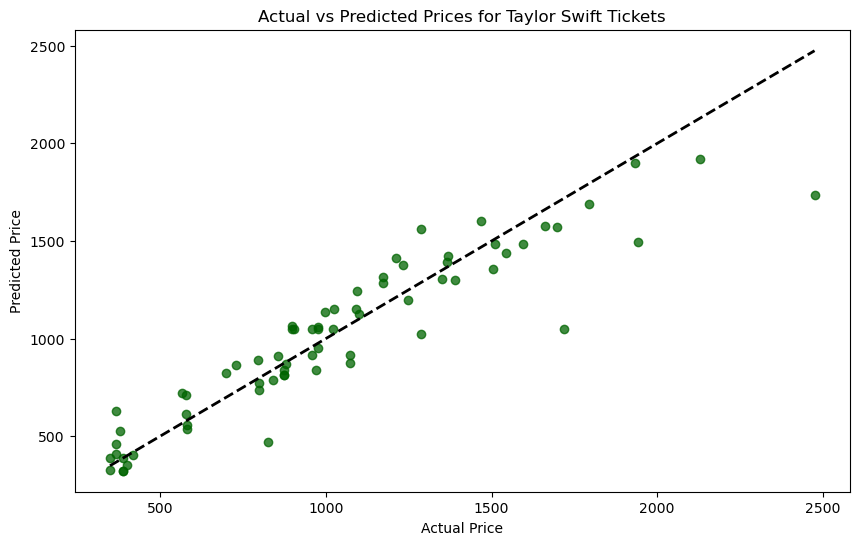

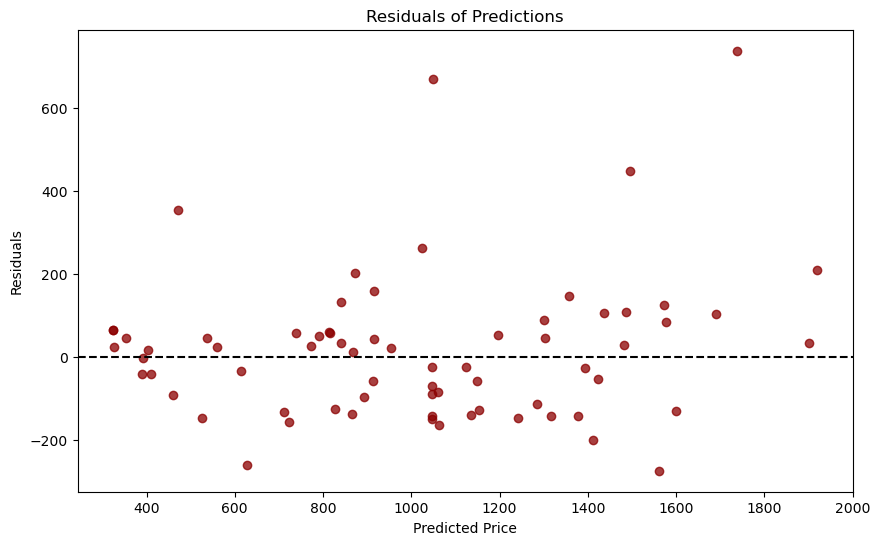

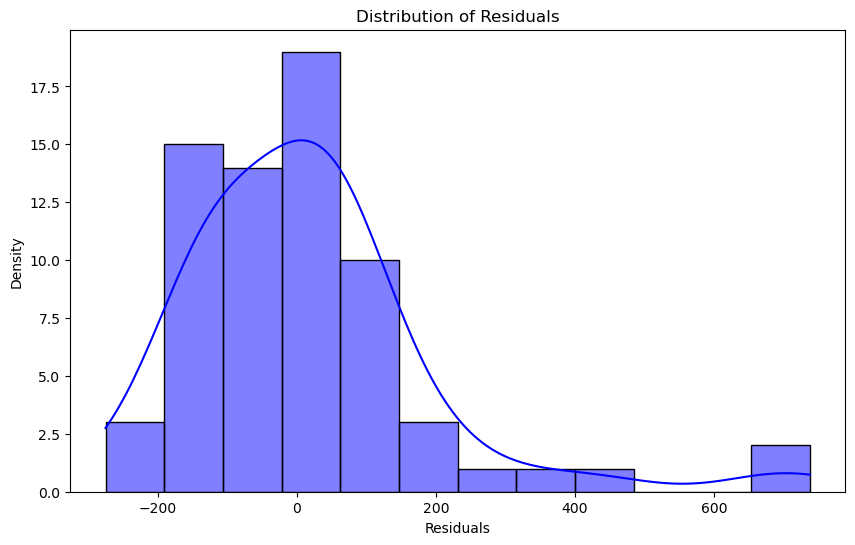

In [300]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

#Filter for Taylor Swift
taylor = df.query("Event.str.contains('Taylor Swift', case=False)")

print(taylor.head())
    
train_set, test_set = train_test_split(taylor, test_size=0.2, random_state=26) #26

X_train = train_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Team Popularity'], axis=1)
y_train = train_set['Sold Price']
X_test = test_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Team Popularity'], axis=1)
y_test = test_set['Sold Price']

model = HistGradientBoostingRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

#Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Taylor Swift Tickets')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.75, color='darkred')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Without Days Before

Mean Squared Error (MSE): 87039.23
Mean Absolute Error (MAE): 213.02
R-squared (R²): 0.60


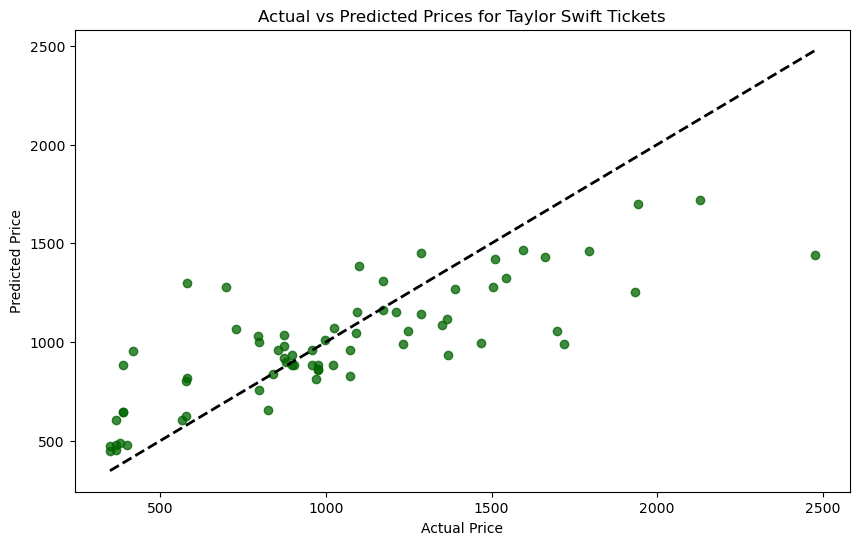

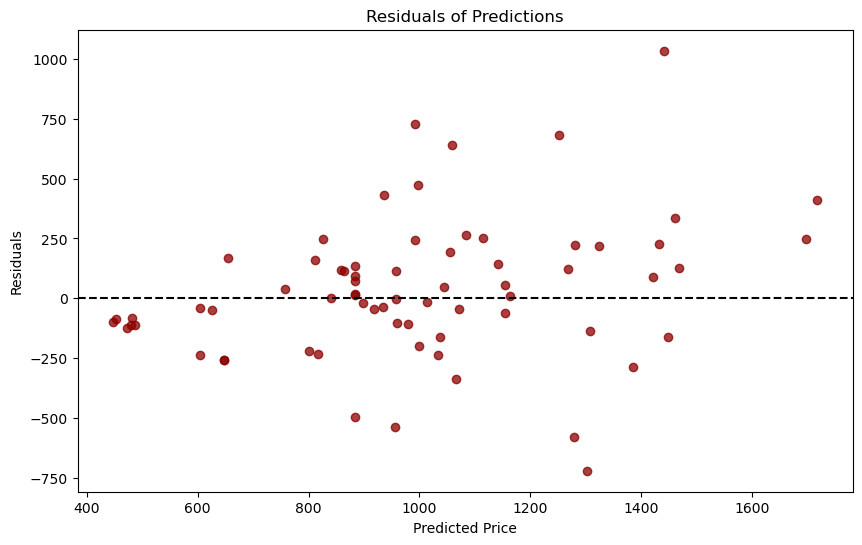

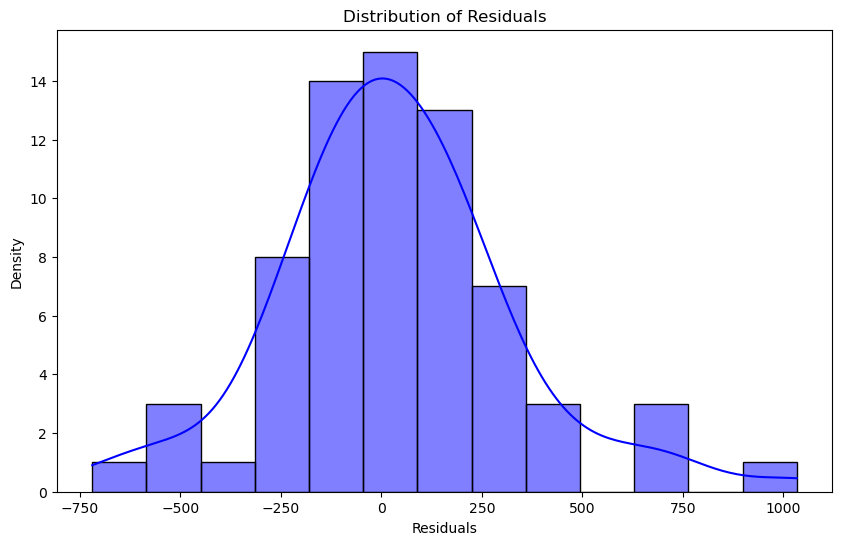

In [288]:
X_train = train_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Days Before', 'Team Popularity'], axis=1)
y_train = train_set['Sold Price']
X_test = test_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Days Before', 'Team Popularity'], axis=1)
y_test = test_set['Sold Price']

model = HistGradientBoostingRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

#Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Taylor Swift Tickets')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.75, color='darkred')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Taylor Swift XGBoost Regressor Model With Days Before

     Section Row  Ticket Qty  Weekday  Days Before
268       10  20           2      6.0        188.0
1755     255  23           2      6.0          0.0
416      306  21           2      5.0        186.0
335      336  25           3      5.0        190.0
1298     248  18           2      6.0          0.0
Mean Squared Error: 326160.98
Feature Importances: [0.27760115 0.2102801  0.         0.12880911 0.38330963]


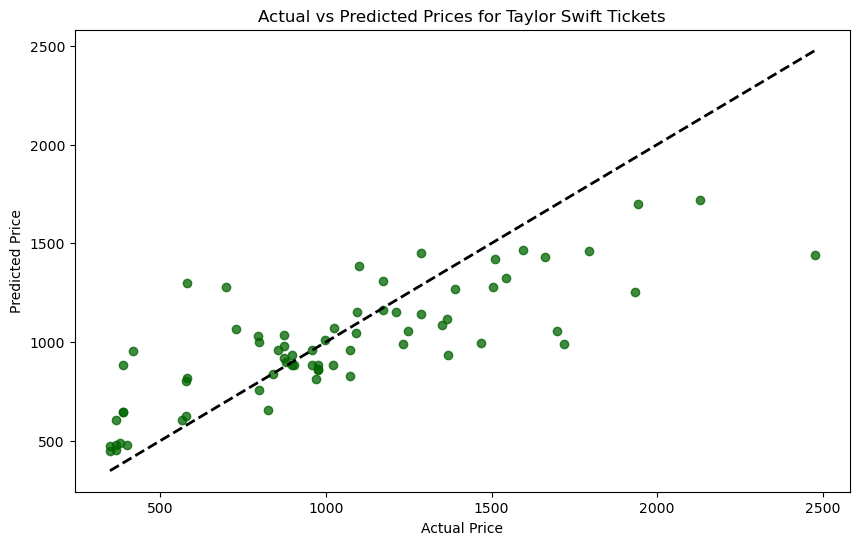

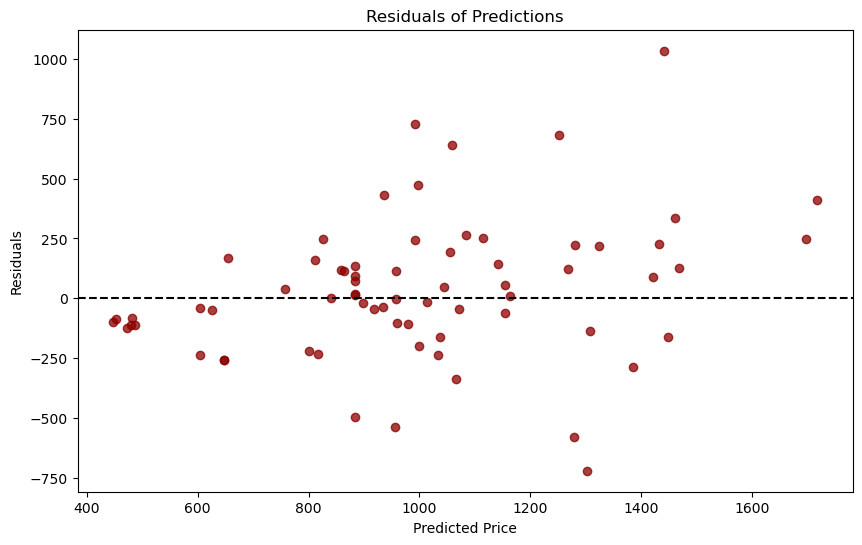

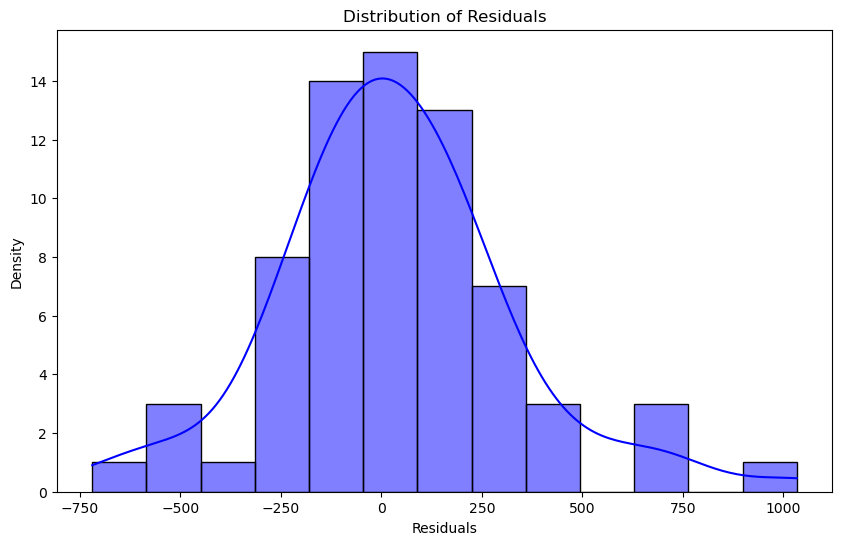

In [289]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

taylor = df.query("Event.str.contains('Taylor Swift', case=False)")

train_set, test_set = train_test_split(taylor, test_size=0.2, random_state=26) #26

X_train = train_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Team Popularity'], axis=1)
y_train = train_set['Sold Price']
X_test = test_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Team Popularity'], axis=1)
y_test = test_set['Sold Price']

print(X_train.head())

for column in ['Section', 'Row', 'Ticket Qty', 'Weekday', 'Days Before']:
    X_train[column] = X_train[column].astype('category')
    X_test[column] = X_test[column].astype('category')

weights = np.random.rand(len(X_train))

model = xgb.XGBRegressor(
    n_estimators=10,
    max_depth=3,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan, 
    random_state=26,
    enable_categorical=True
)

model.fit(X_train, y_train, sample_weight=weights)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.2f}")
importances = model.feature_importances_
print(f"Feature Importances: {importances}")

#Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Taylor Swift Tickets')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.75, color='darkred')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Without Days Before

Mean Squared Error: 294985.36
Feature Importances: [0.37833643 0.33655113 0.08338759 0.20172492]


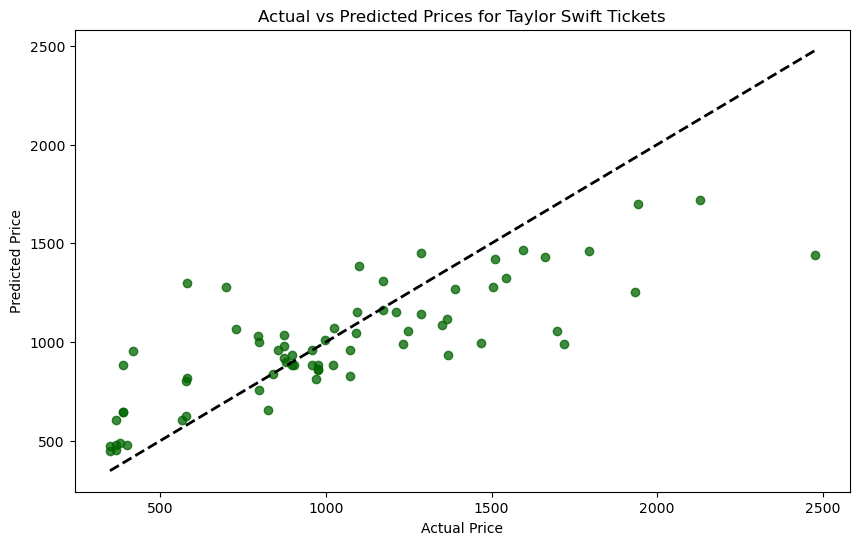

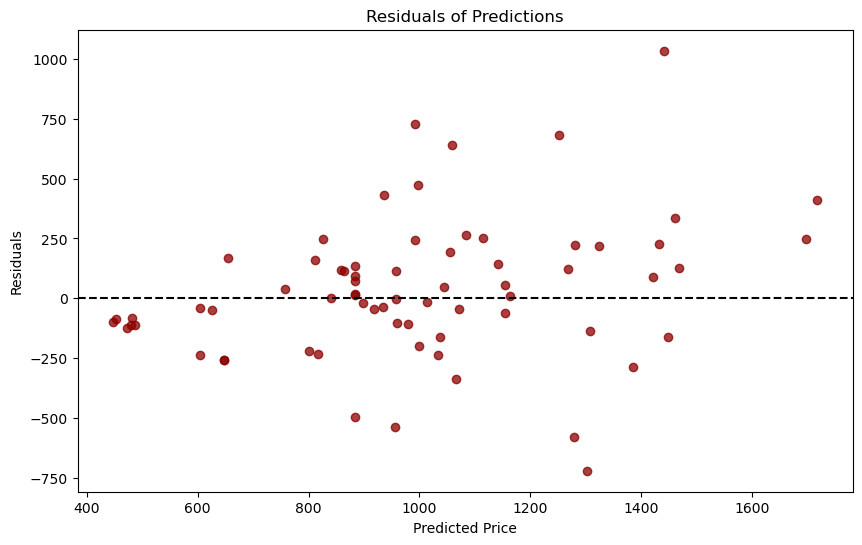

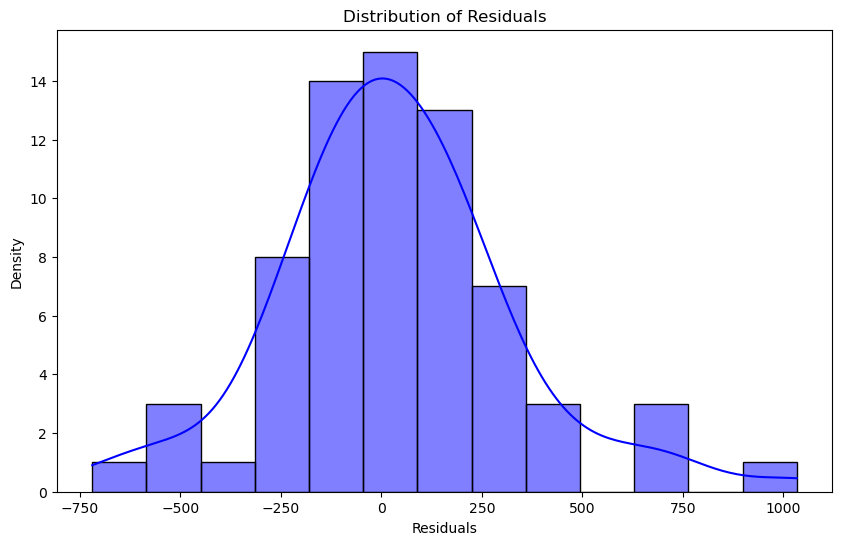

In [291]:
X_train = train_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Days Before', 'Team Popularity'], axis=1)
y_train = train_set['Sold Price']
X_test = test_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Days Before', 'Team Popularity'], axis=1)
y_test = test_set['Sold Price']

for column in ['Section', 'Row', 'Ticket Qty', 'Weekday']:
    X_train[column] = X_train[column].astype('category')
    X_test[column] = X_test[column].astype('category')

weights = np.random.rand(len(X_train))

model = xgb.XGBRegressor(
    n_estimators=10,
    max_depth=3,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan, 
    random_state=26,
    enable_categorical=True
)

model.fit(X_train, y_train, sample_weight=weights)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.2f}")
importances = model.feature_importances_
print(f"Feature Importances: {importances}")

#Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Taylor Swift Tickets')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.75, color='darkred')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Raiders HistGradientBoostingRegressor Model With Days Before

    Invoice Date                                              Event  \
51      8/7/2022  NFL Preseason: Miami Dolphins vs. Las Vegas Ra...   
102    8/29/2022            Las Vegas Raiders vs. Arizona Cardinals   
103    8/30/2022            Las Vegas Raiders vs. Arizona Cardinals   
104    8/27/2022            Las Vegas Raiders vs. Arizona Cardinals   
133    8/28/2022          Las Vegas Raiders vs. San Francisco 49ers   

    Event Date Event Time Section Row  Ticket Qty  Sold Price Team Popularity  \
51     8/20/22   19:00:00     355  21           3        7.00               1   
102    9/18/22   13:25:00     137  34           2      606.28               0   
103    9/18/22   13:25:00     123  30           2      349.69               0   
104    9/18/22   13:25:00     415  19           2      247.48               0   
133     1/1/23   13:05:00     410  21           2      413.08               3   

     Weekday  Days Before  
51       5.0         13.0  
102      6.0         20.0  
10

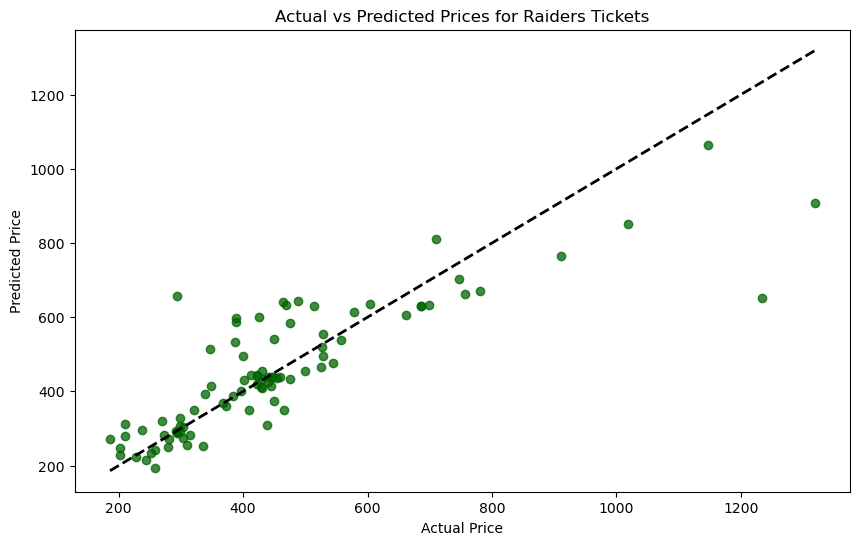

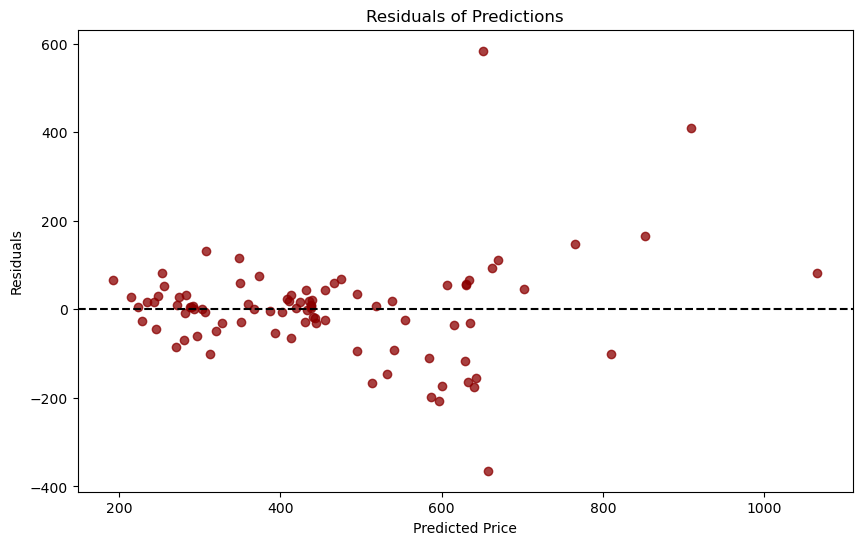

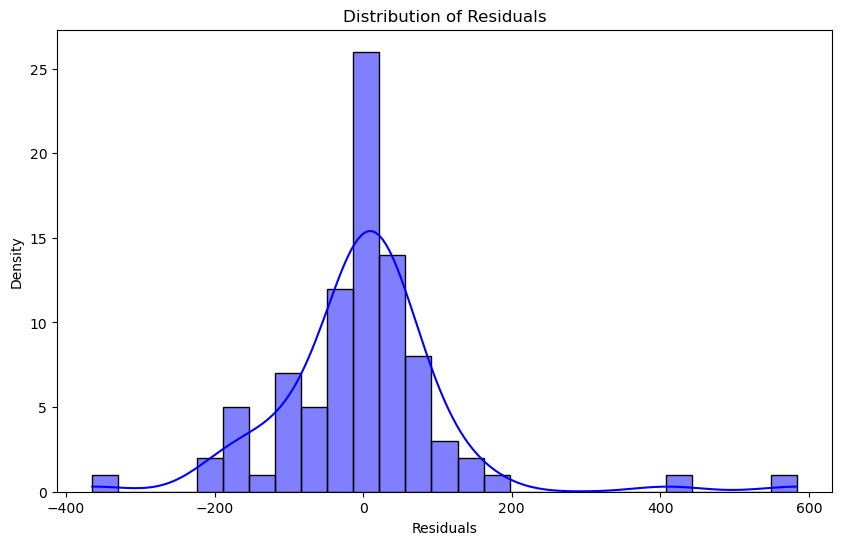

In [296]:
#filter for Raiders
raiders = df.query("Event.str.contains('Raiders', case=False)")

print(raiders.head())

train_set, test_set = train_test_split(raiders, test_size=0.2, random_state=26) #26

X_train = train_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event'], axis=1)
y_train = train_set['Sold Price']
X_test = test_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event'], axis=1)
y_test = test_set['Sold Price']

model = HistGradientBoostingRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

#Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Raiders Tickets')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.75, color='darkred')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Without Days Before

Mean Squared Error (MSE): 11337.11
Mean Absolute Error (MAE): 72.73
R-squared (R²): 0.75


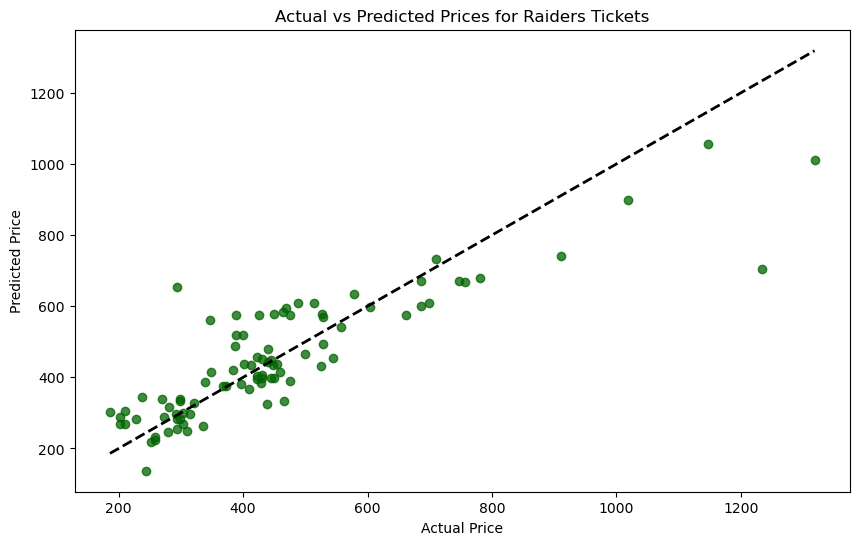

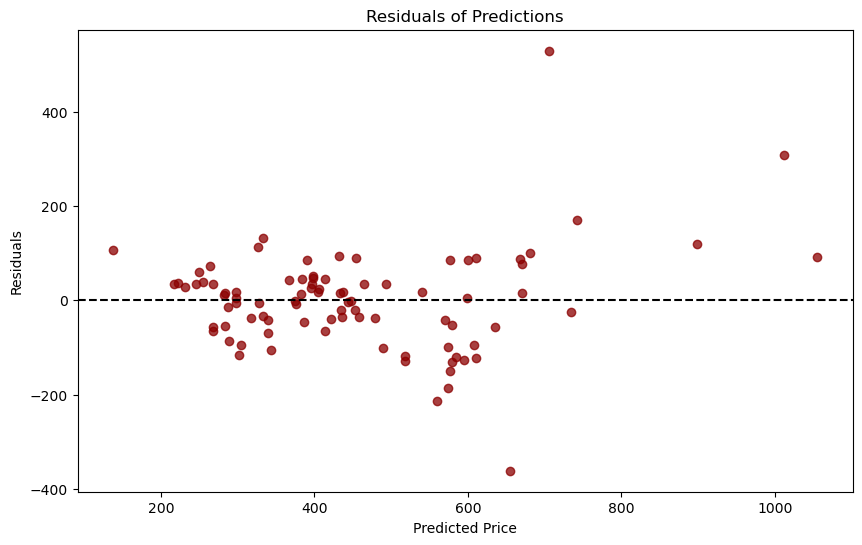

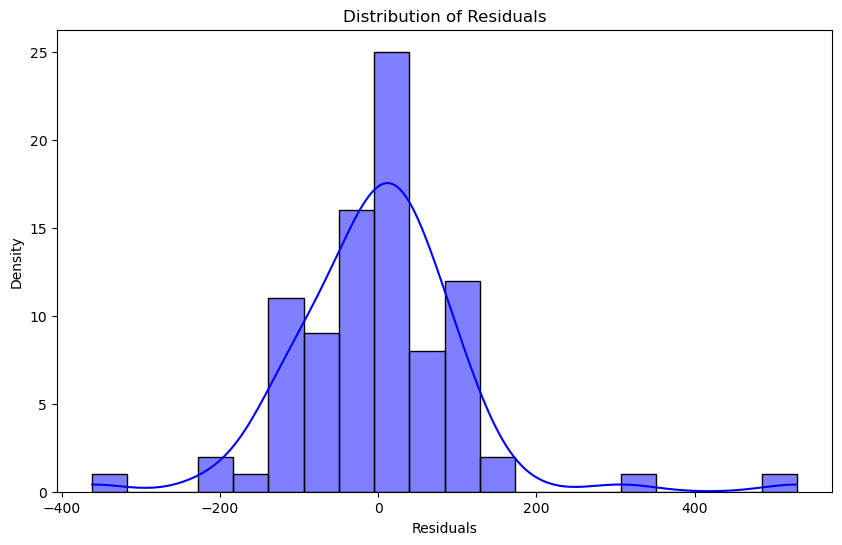

In [297]:
train_set, test_set = train_test_split(raiders, test_size=0.2, random_state=26) #26

X_train = train_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Days Before'], axis=1)
y_train = train_set['Sold Price']
X_test = test_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Days Before'], axis=1)
y_test = test_set['Sold Price']

model = HistGradientBoostingRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

#Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Raiders Tickets')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.75, color='darkred')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Raiders XBoost Regressor Model With Days Before

     Section Row  Ticket Qty Team Popularity  Weekday  Days Before
809      345  12           2               0      6.0         59.0
781      110  23           2               3      6.0         19.0
1180     113  31           1               2      6.0          0.0
1557     112  25           2               1      6.0         55.0
1050     123  30           2               3      6.0         55.0
Mean Squared Error: 51888.46
Feature Importances: [0.45868194 0.11323637 0.01427035 0.1953376  0.08548574 0.13298793]


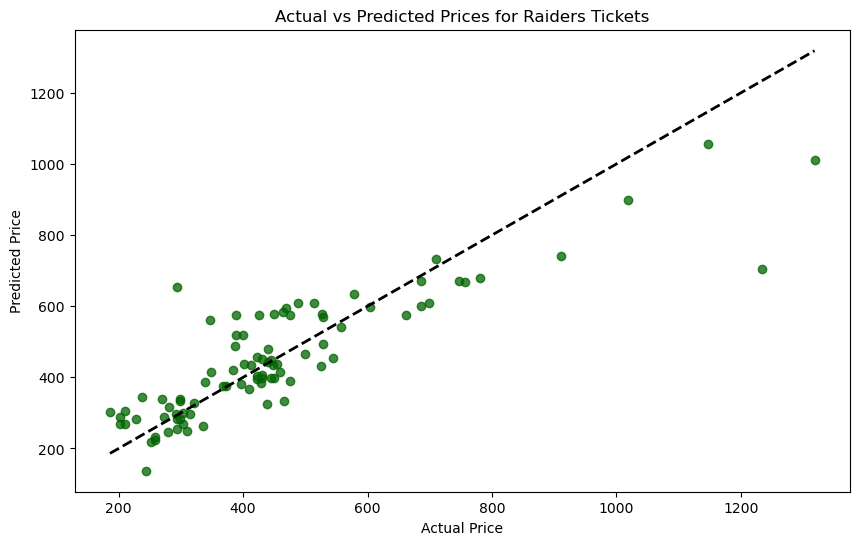

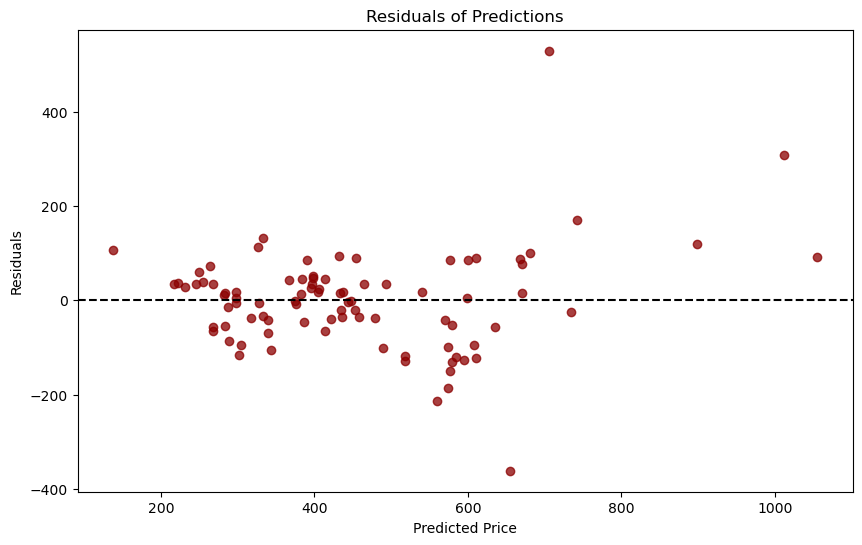

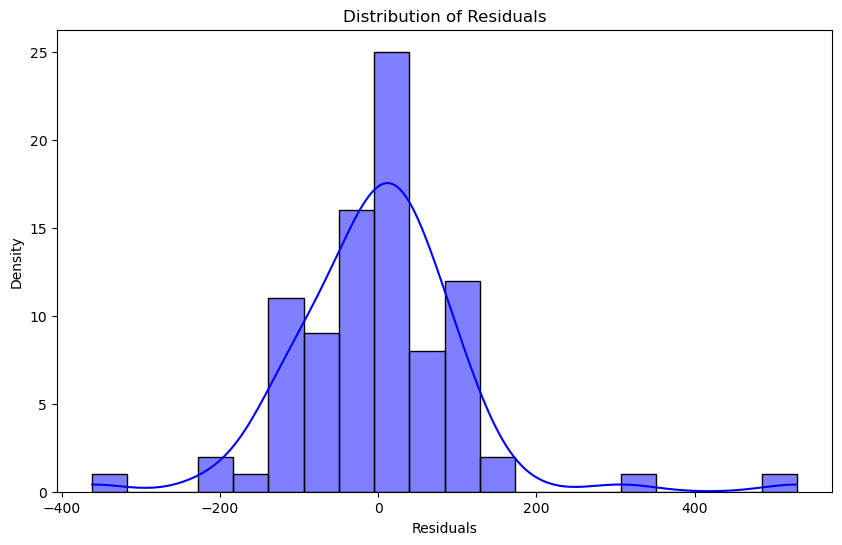

In [298]:
train_set, test_set = train_test_split(raiders, test_size=0.2, random_state=26) #26

X_train = train_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event'], axis=1)
y_train = train_set['Sold Price']
X_test = test_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event'], axis=1)
y_test = test_set['Sold Price']

print(X_train.head())

for column in ['Section', 'Row', 'Ticket Qty', 'Weekday', 'Days Before', 'Team Popularity']:
    X_train[column] = X_train[column].astype('category')
    X_test[column] = X_test[column].astype('category')

weights = np.random.rand(len(X_train))

model = xgb.XGBRegressor(
    n_estimators=10,
    max_depth=3,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan, 
    random_state=26,
    enable_categorical=True
)

model.fit(X_train, y_train, sample_weight=weights)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.2f}")
importances = model.feature_importances_
print(f"Feature Importances: {importances}")

#Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Raiders Tickets')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.75, color='darkred')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Without Days Before

     Section Row  Ticket Qty Team Popularity  Weekday
809      345  12           2               0      6.0
781      110  23           2               3      6.0
1180     113  31           1               2      6.0
1557     112  25           2               1      6.0
1050     123  30           2               3      6.0
Mean Squared Error: 40257.19
Feature Importances: [0.4270605  0.2216698  0.03971327 0.21393749 0.09761896]


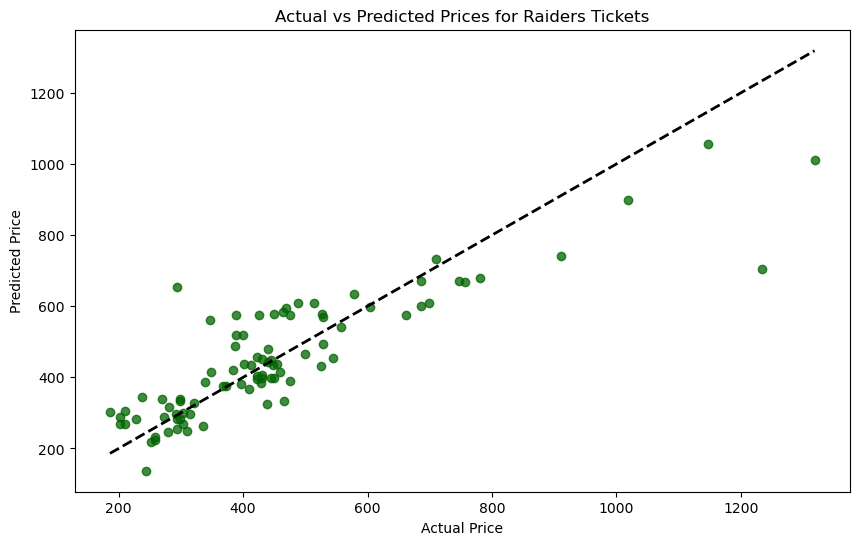

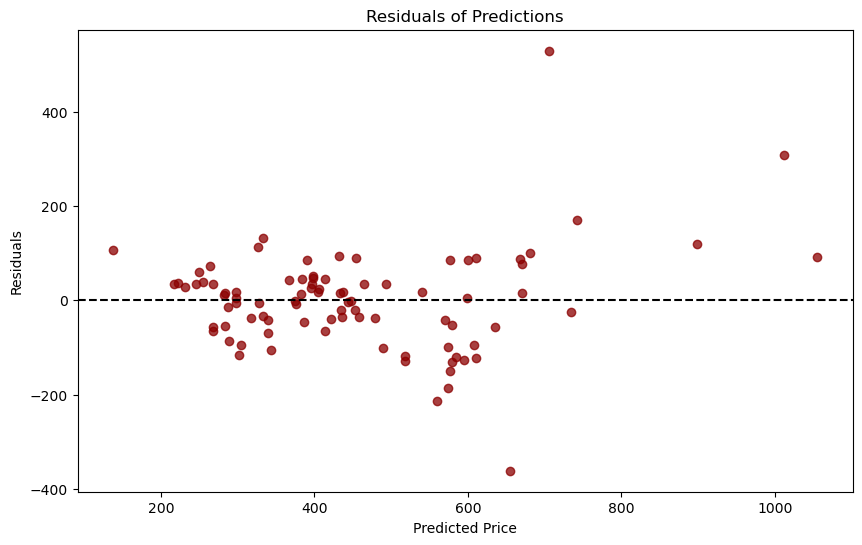

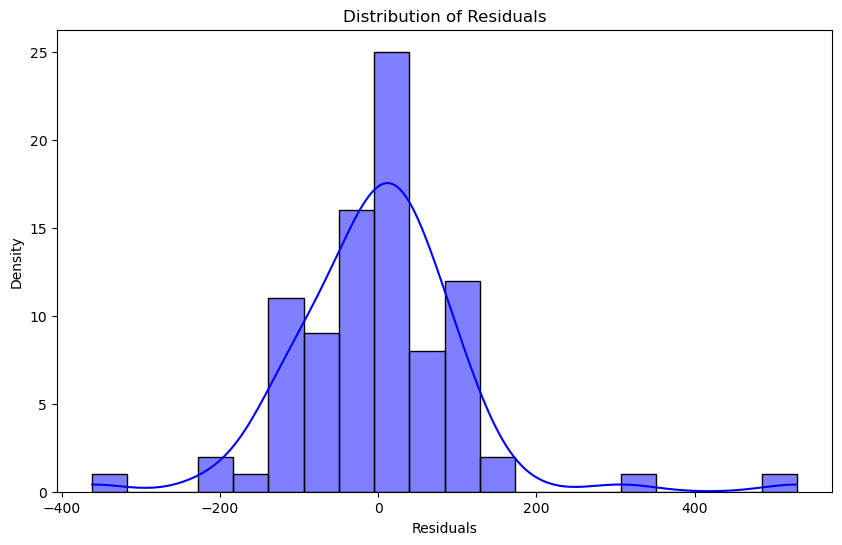

In [299]:
train_set, test_set = train_test_split(raiders, test_size=0.2, random_state=26) #26

X_train = train_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Days Before'], axis=1)
y_train = train_set['Sold Price']
X_test = test_set.drop(['Sold Price', 'Invoice Date', 'Event Date', 'Event Time', 'Event', 'Days Before'], axis=1)
y_test = test_set['Sold Price']

print(X_train.head())

for column in ['Section', 'Row', 'Ticket Qty', 'Weekday', 'Team Popularity']:
    X_train[column] = X_train[column].astype('category')
    X_test[column] = X_test[column].astype('category')

weights = np.random.rand(len(X_train))

model = xgb.XGBRegressor(
    n_estimators=10,
    max_depth=3,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan, 
    random_state=26,
    enable_categorical=True
)

model.fit(X_train, y_train, sample_weight=weights)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.2f}")
importances = model.feature_importances_
print(f"Feature Importances: {importances}")

#Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Raiders Tickets')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.75, color='darkred')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()